In [45]:
import pandas as pd 
import glob
import jsonlines
import json
import re
import logging
from tqdm.auto import tqdm

In [23]:
all_summary_files = glob.glob('../data/v3_sources/v3_source_summaries/*summaries*')
all_centrality_files = glob.glob('../data/v3_sources/v3_source_summaries/*centrality*')
all_discourse_files = glob.glob('../data/v3_sources/v3_source_summaries/*narrative-keyword*')

In [138]:
def robust_read_jsonlist(f):
    all_lines = []
    for line in open(f, encoding='utf-8'):
        try:
            all_lines.append(json.loads(line))
        except:
            print('error')
    return pd.DataFrame(all_lines, columns=['url', 'response'])


def robust_parse_narr_json_str(t):
    t = t.replace(']','').replace('[','').replace('`', '').strip()
    t2_chunks = re.split(r'\},\s+\{', t)
    
    all_ds = []
    for t2 in t2_chunks:
        d = {}
        t3_chunks = t2.replace('{', '').replace('}', '').strip().split('\n')
        for t3 in t3_chunks:
            for k in keys:
                if 'Name' in t3:
                    d['Name'] = t3.replace('"Name":', '').strip().removeprefix('"').removesuffix('",')
                if 'Narrative Function' in t3:
                    d['Narrative Function'] = t3.replace('"Narrative Function":', '').strip()
        all_ds.append(d)
    return all_ds
    

def robust_extract_json_str(lm_string):
    if not lm_string:
        return None
    # Use regular expressions to search for list brackets across multiple lines
    match = re.search(r'\[.*?\]', lm_string, re.DOTALL)
    if match:
        lm_string = match.group(0)
    try:
        return json.loads(lm_string)
    except:
        try:
            return ast.literal_eval(lm_string)
        except:
            pass
    # logging.error(f"Could not extract json string from: {lm_string}")
    return []

In [139]:
all_summs = []
for f in tqdm(all_summary_files):
    all_summ_df = (
        robust_read_jsonlist(f)
        .assign(source_summaries=lambda df: df['response'].apply(robust_extract_json_str))
    )
    all_summs.append(all_summ_df)

all_discourse = []
for f in tqdm(all_discourse_files):
    all_disc_df = (
        robust_read_jsonlist(f)
        .assign(source_discourse=lambda df: df['response'].apply(robust_parse_narr_json_str))
    )
    all_discourse.append(all_disc_df)

all_centrality = []
for f in tqdm(all_centrality_files):
    all_cent_df = (
        robust_read_jsonlist(f)
        .assign(source_cent=lambda df: df['response'].apply(robust_extract_json_str))
    )
    all_centrality.append(all_cent_df)

  0%|          | 0/489 [00:00<?, ?it/s]

error


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 0/482 [00:00<?, ?it/s]

In [140]:
full_summ_df = pd.concat(all_summs)
full_disc_df = pd.concat(all_discourse)
full_cent_df = pd.concat(all_centrality)

#.loc[lambda df: df['source_summaries'].str.len() == 0].shape

In [221]:
source_summ_df = (
    full_summ_df
        .loc[lambda df: (df['source_summaries'].str.len() < 20) & (df['source_summaries'].str.len() > 1)]
        .drop(columns='response')
        .explode('source_summaries').reset_index(drop=True)
            .pipe(lambda df: pd.concat([
                df[['url']], pd.DataFrame(df['source_summaries'].tolist())
            ], axis=1)
         )
        .drop_duplicates(['url', 'Name'])
)

source_disc_df = (
    full_disc_df
        .drop(columns='response')
        .explode('source_discourse').reset_index(drop=True)
            .pipe(lambda df: pd.concat([
                df[['url']], pd.DataFrame(df['source_discourse'].tolist())
            ], axis=1)
         )
        .drop_duplicates(['url', 'Name'])
)

source_cent_df = (
    full_cent_df
        .drop(columns='response')
        .explode('source_cent')
        .loc[lambda df: df['source_cent'].notnull()]
        .loc[lambda df: df['source_cent'].apply(type) == dict]
        .reset_index(drop=True)
            .pipe(lambda df: pd.concat([
                df[['url']], pd.DataFrame(df['source_cent'].tolist())
            ], axis=1)
         )
        [['url', 'Name', 'Perspective', 'Centrality', 'Is_Error', 'Justification']]
        .dropna()
        .drop_duplicates(['url', 'Name'])
)

In [222]:
source_summ_df.shape

(560753, 5)

In [223]:
source_disc_df.shape

(758619, 3)

In [224]:
source_cent_df.shape

(557556, 6)

In [236]:
full_source_df = (
    source_summ_df
        .merge(source_disc_df, on=['url', 'Name'])
        .merge(source_cent_df, on=['url', 'Name'])
        .loc[lambda df: df['Is_Error'] == 'No']
        .drop(columns='Note')
)

In [272]:
perp_col_order = [
    'Authoritative',
    'Supportive',
    'Neutral',
    'Against',
    'Skeptical',
    'Informative',  
]
cent_col_order = ['High', 'Medium', 'Low']

In [273]:
full_source_df['Perspective'] = (
    full_source_df['Perspective']
        .apply(lambda x: x if x in to_keep_perp else 'Informative')
)

In [274]:
import seaborn as sns

<Axes: xlabel='Perspective'>

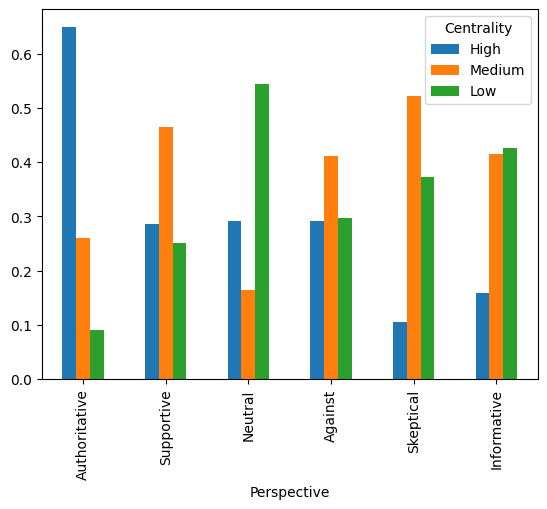

In [276]:
(
    full_source_df[['Perspective', 'Centrality']]
        .value_counts()
        .unstack().loc[perp_col_order, cent_col_order]
        .pipe(lambda df: df.divide(df.sum(axis=1), axis=0))
        .plot(kind='bar')
)